In [1]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'RELI Historical Data (1).csv'
df = pd.read_csv(file_path)

# Show the first few rows and structure
df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,01-01-2024,"1,295.13","1,290.28","1,303.43","1,286.57",4.03M,0.21%
1,29-12-2023,"1,292.47","1,305.55","1,307.00","1,289.65",10.86M,-0.79%
2,28-12-2023,"1,302.78","1,294.90","1,306.00","1,293.43",12.30M,0.72%
3,27-12-2023,"1,293.43","1,291.00","1,299.95","1,286.55",9.20M,0.34%
4,26-12-2023,"1,289.03","1,284.00","1,295.97","1,281.35",7.47M,0.51%


In [2]:
import numpy as np

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

# Remove commas and convert 'Price' to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Calculate daily returns
df['Returns'] = df['Price'].pct_change()

# Drop missing values
df = df.dropna().reset_index(drop=True)

# Keep only necessary columns
df_returns = df[['Date', 'Returns']]
df_returns.set_index('Date', inplace=True)
df_returns.head()


,Returns
Date,
2023-01-03,-0.007321
2023-01-04,-0.015060
2023-01-05,-0.001784
2023-01-06,0.009087
2023-01-09,0.023611


In [3]:
# EWMA volatility with lambda = 0.94
lambda_ = 0.94
ewma_var = [df_returns['Returns'].var()]

for r in df_returns['Returns'][1:]:
    new_var = lambda_ * ewma_var[-1] + (1 - lambda_) * r**2
    ewma_var.append(new_var)

# Convert to daily volatility (standard deviation)
df_returns['EWMA Volatility'] = np.sqrt(ewma_var)


<ipython-input-3-2f6919c03d91>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['EWMA Volatility'] = np.sqrt(ewma_var)


In [7]:
!pip install arch
from arch import arch_model

arch_mod = arch_model(df_returns['Returns'], vol='ARCH', p=1)
arch_res = arch_mod.fit(disp="off")

df_returns['ARCH Volatility'] = arch_res.conditional_volatility


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-7-5118263e249d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['ARCH Volatility'] = arch_res.conditional_volatility


In [8]:
garch_mod = arch_model(df_returns['Returns'], vol='GARCH', p=1, q=1)
garch_res = garch_mod.fit(disp="off")

df_returns['GARCH Volatility'] = garch_res.conditional_volatility


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-8-ebfe2d88576f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['GARCH Volatility'] = garch_res.conditional_volatility


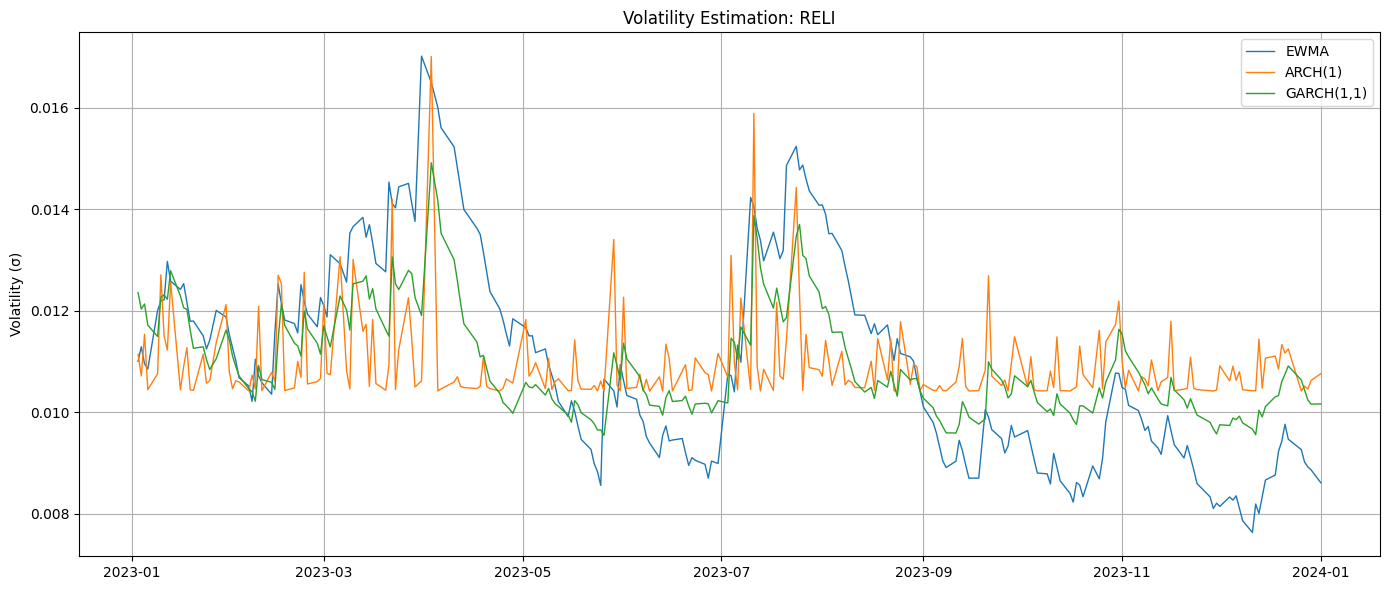

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_returns.index, df_returns['EWMA Volatility'], label='EWMA', linewidth=1)
plt.plot(df_returns.index, df_returns['ARCH Volatility'], label='ARCH(1)', linewidth=1)
plt.plot(df_returns.index, df_returns['GARCH Volatility'], label='GARCH(1,1)', linewidth=1)
plt.title("Volatility Estimation: RELI")
plt.ylabel("Volatility (σ)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [10]:
# Z-score for 95% confidence
z_95 = 1.65

# Compute 1-day VaR (as % return)
df_returns['VaR (95%) - EWMA'] = -z_95 * df_returns['EWMA Volatility']

# Optional: Convert to monetary VaR (e.g., on ₹1 lakh investment)
investment = 100000  # You can change this
df_returns['VaR Rupees (95%) - EWMA'] = df_returns['VaR (95%) - EWMA'] * investment

df_returns[['EWMA Volatility', 'VaR (95%) - EWMA', 'VaR Rupees (95%) - EWMA']].tail()


<ipython-input-10-2296f6f275bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['VaR (95%) - EWMA'] = -z_95 * df_returns['EWMA Volatility']
<ipython-input-10-2296f6f275bb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['VaR Rupees (95%) - EWMA'] = df_returns['VaR (95%) - EWMA'] * investment


,EWMA Volatility,VaR (95%) - EWMA,VaR Rupees (95%) - EWMA
Date,,,
2023-12-26,0.009264,-0.015286,-1528.605936
2023-12-27,0.009021,-0.014884,-1488.445684
2023-12-28,0.008924,-0.014724,-1472.379956
2023-12-29,0.008866,-0.014629,-1462.919331
2024-01-01,0.008611,-0.014208,-1420.789907


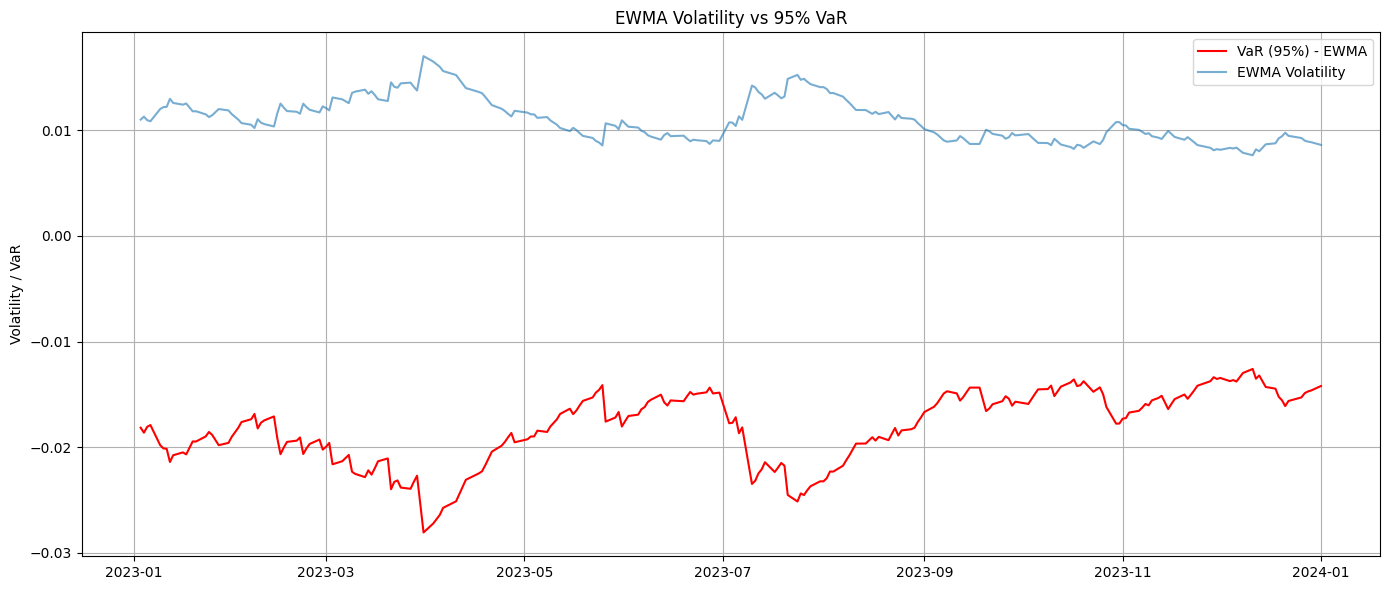

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df_returns.index, df_returns['VaR (95%) - EWMA'], label='VaR (95%) - EWMA', color='red')
plt.plot(df_returns.index, df_returns['EWMA Volatility'], label='EWMA Volatility', alpha=0.6)
plt.title('EWMA Volatility vs 95% VaR')
plt.ylabel('Volatility / VaR')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
